In [7]:
import HeST as hest
import HeST.Amherst_Example_Detector as examp
import HeST.LBNL_Example_Detector as lbl
import numpy as np
import matplotlib.pyplot as plt

import astropy.stats as astat

# Load the example detector based on the Amherst cell

In [13]:

detector = lbl.DetectorExample_LBNL


ph_conditions = detector.get_surface_conditions()
nCPDs = detector.get_nCPDs()
for i in range(nCPDs):
    ph_conditions.append( (detector.get_CPD(i)).get_surface_condition() )

QP_conditions = ph_conditions.copy()
QP_conditions.append( detector.liquid_surface )


## Use the WIMP Generator to create an energy spectrum, and compare to a flat ER signal.
### Generate quanta, and then convert the total number of singlet photons and quasiparticles into observable pulse areas, in eV.

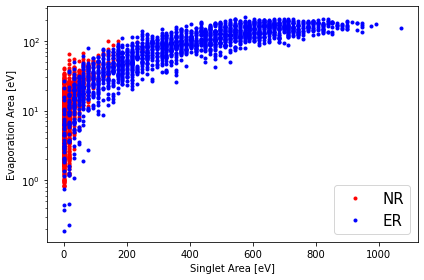

In [3]:

#create a WIMP energy spectrum!
spectrum_WIMP = []
mass = 5000 # MeV
nEvents = 2000

prep = hest.WIMP_spectrum_prep(mass)
for i in range(nEvents):
    spectrum_WIMP.append( hest.WIMP_spectrum(mass, *prep) )
    

spectrum_BG = np.random.uniform(20, 10000, size=nEvents) #20eV to 10keV


nrSinglet, nrTriplet, nrQP = [], [], []
erSinglet, erTriplet, erQP = [], [], []
for i in range(nEvents):
    q = hest.GetQuanta(spectrum_WIMP[i], "NR")
    sig = hest.GetSingletSignal(detector, q.SingletPhotons, 0, 0, 1)
    evap = hest.GetEvaporationSignal( detector, q.Quasiparticles, 0, 0, 1)
    nrSinglet.append( sig.area_eV )
    nrQP.append( evap.area_eV )
    
    q = hest.GetQuanta(spectrum_BG[i], "ER")
    sig = hest.GetSingletSignal(detector, q.SingletPhotons, 0, 0, 1)
    evap = hest.GetEvaporationSignal( detector, q.Quasiparticles, 0, 0, 1)
    erSinglet.append( sig.area_eV )
    erQP.append( evap.area_eV )
    
    
nrSinglet, nrTriplet, nrQP = np.array(nrSinglet), np.array(nrTriplet), np.array(nrQP)
erSinglet, erTriplet, erQP = np.array(erSinglet), np.array(erTriplet), np.array(erQP)

plt.plot( nrSinglet, nrQP, 'r o', ms=3, label='NR')
plt.plot( erSinglet, erQP, 'b o', ms=3, label='ER')

plt.xlabel('Singlet Area [eV]')
plt.ylabel('Evaporation Area [eV]')
#plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.legend(loc='best', fontsize=15)
plt.show()

3 photons, 109027 QPs
868.0 [263.5, 217.0, 139.5, 170.5, 15.5, 31.0, 15.5, 15.5] 8 56
0.0 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 0 0


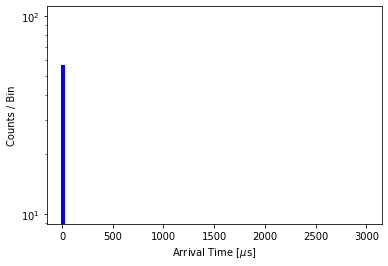

CPU times: user 1.67 s, sys: 20.4 ms, total: 1.69 s
Wall time: 1.68 s


In [12]:
%%time
#Look at arrival times of photons and QPs!

energy = 150 #eV
q = hest.GetQuanta(energy, "ER")

print("%i photons, %i QPs" % (q.SingletPhotons, q.Quasiparticles))

pos = [0., 0., 1.5]
useMap = False
sig = hest.GetSingletSignal(detector, 1000, *pos, useMap=useMap)
print( sig.area_eV, sig.chArea_eV, sig.coincidence, len(sig.arrivalTimes_us))
evap = hest.GetEvaporationSignal( detector, 5000, *pos, useMap=useMap)
print( evap.area_eV, evap.chArea_eV, evap.coincidence, len(evap.arrivalTimes_us))


plt.hist(sig.arrivalTimes_us, bins=200, range=[0, 3000], histtype='step', color='b', lw=2)
plt.hist(evap.arrivalTimes_us, bins=200, range=[0, 3000], histtype='step', color='r', lw=2)
plt.yscale('log')
plt.xlabel(r'Arrival Time [$\mu$s]')
plt.ylabel('Counts / Bin')
plt.show()


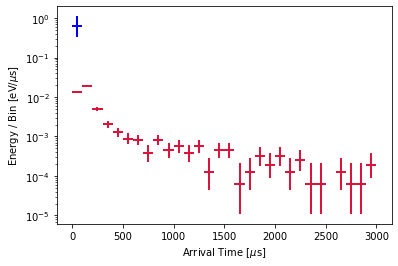

In [6]:
#normalize the arrival time histograms to total pulse area

bins = 30
lims = [0, 3000]

#create the histogram
histY, histX = np.histogram(sig.arrivalTimes_us, bins=bins, range=lims)
binCenters = np.array([np.mean([histX[i], histX[i+1]]) for i in range(len(histY))])
binSize = binCenters[1]-binCenters[0]
histN = sum(histY)
#get actual poisson error bars per bin, not just root-N
histErrLo, histErrHi = astat.poisson_conf_interval(histY, interval='frequentist-confidence', sigma=1)
histErrLo = histY - histErrLo
histErrHi = histErrHi - histY

#normalize to pulse area
histY = histY / histN / binSize   * sig.area_eV
histErrLo = histErrLo / histN / binSize * sig.area_eV
histErrHi = histErrHi / histN / binSize * sig.area_eV

plot_cut = (histY > 0.)
plt.errorbar( binCenters[plot_cut], histY[plot_cut], xerr=binSize/2., yerr=[histErrLo[plot_cut], histErrHi[plot_cut]], color='blue', lw=2, markersize=0, linestyle='none')

histY, histX = np.histogram(evap.arrivalTimes_us, bins=bins, range=lims)
binCenters = np.array([np.mean([histX[i], histX[i+1]]) for i in range(len(histY))])
binSize = binCenters[1]-binCenters[0]
histN = sum(histY)

#get actual poisson error bars per bin, not just root-N
histErrLo, histErrHi = astat.poisson_conf_interval(histY, interval='frequentist-confidence', sigma=1)
histErrLo = histY - histErrLo
histErrHi = histErrHi - histY

#normalize to pulse area
histY = histY / histN / binSize * evap.area_eV
histErrLo = histErrLo / histN / binSize * evap.area_eV
histErrHi = histErrHi / histN / binSize * evap.area_eV

plot_cut = (histY > 0.)
plt.errorbar( binCenters[plot_cut], histY[plot_cut], xerr=binSize/2., yerr=[histErrLo[plot_cut], histErrHi[plot_cut]], color='crimson', lw=2, markersize=0, linestyle='none')

plt.yscale('log')
plt.xlabel(r'Arrival Time [$\mu$s]')
plt.ylabel(r'Energy / Bin [eV/$\mu$s]')
plt.show()


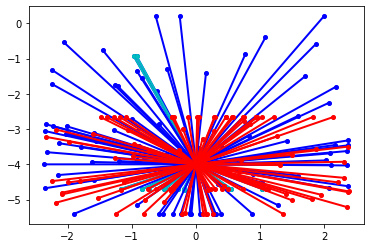

In [21]:
reflection_prob = 0.
pos = [0., 0., -4.]
nPhotons = 100
nQPs = 100
ph_times, qp_times = [], []
s_x, s_z = [], []
for n in range(nPhotons):
        hit, time, n, xs, ys, zs, cpd_id = hest.photon_propagation(pos, ph_conditions, reflection_prob)
        plt.plot(xs, zs, 'b-o', lw=2, ms=4)
        if hit > 0.5:
            plt.plot(xs, zs, 'c-o', lw=2, ms=4)
            ph_times.append( time )

for n in range(nQPs):
        hit, time, n, xs, ys, zs, p, surface, cpd_id = hest.QP_propagation(pos, QP_conditions, reflection_prob)
        plt.plot(xs, zs, 'r-o', lw=2, ms=4)

        if hit > 0.5:
            plt.plot(xs, zs, 'y-o', lw=2, ms=4)
            QP_times.append( time )
            QP_momenta.append( p )
            
plt.show()
